# NordPool Data Analysis

**Introduction**

This is an analysis of hourly electricity spot price data in the Nordics (excl. Iceland) and the Baltics. The data is freely available on https://www.nordpoolgroup.com/historical-market-data/.

NordPool was established in 1993 by the Norwegian TSO Statnett after the Norwegian parliament decided to deregulate the electricity market in 1991. This was the first deregulated market in the world, and NordPool expanded in 1996 to also cover the Swedish market. In 1998 Finland joined, and in 2000 Denmark also became part of the join electricity trade market. 


This analysis is created by Rasmus Vester Thøgersen and made available on GitHub through the MIT License. Link to the GitHub-repository: https://github.com/rasmusthog/nordpool-data-analysis

# 1. Importing data and EDA

Let's start importing the data and doing some exploratory data analysis (EDA). 

The data has been cleaned using a seperate script called "import_data.py", available at the GitHub repository. This imports the hourly elspot price files in .CSV-format (manually exported from .XLS due to some import errors), cleans the data and concatenates the files into a single .CSV-file containing data from 2014-2018.

count    39839.000000
mean        28.305711
std          9.116175
min          1.140000
25%         23.710000
50%         27.980000
75%         32.230000
max        199.970000
Name: SYS, dtype: float64


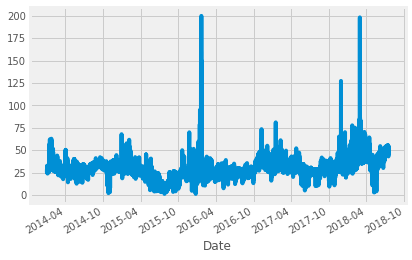

In [87]:
# importing modules
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# importing full dataset

elspot_df = pd.read_csv("datasets/total-elspot-prices_2014-2018.csv", delimiter=",", header=0, index_col="Date", parse_dates=True)

# Look at the description and visual plot of the system price.
print(elspot_df["SYS"].describe())
elspot_df["SYS"].plot()


The graph shows two very large peaks, as well as one slightly smaller. Turns out that the two large peaks occured on 21st January 2016 (at 08:00 and 18:00) and 1st March 2018 (at 08:00). These peak correspond to about 7 times the mean elspot price. Not sure if these are valid data points or not, but I have contacted NordPool to ask them about this.

# 2. Investigating differences _within_ countries

Each country may have several bidding areas, or price regions. These are decided by the local transmission system operator (TSO), and are subject to change over time. Today, the following bidding areas exist: 

- Norway: NO1, NO2, NO3, NO4, NO5
- Sweden: SE1, SE2, SE3, SE4
- Denmark: DK1, DK2
- Finland: FI
- Latvia: LV
- Lithuania: LT
- Estonia: EE

<img src="img/bidding-areas.png" width="400px">


The reason for the division is due to the limited transmission capacity between different geographical areas, as flow may be congested and price differences may help curb demand or up supply in congested areas. 

Let's investigate the evolution of the prices in the different countries, and compare to the mean overall system price (marked with a red horizontal line) for the past 4,5 years. In order to smoothe out the large fluctuations we may have due to the high resolution of the data (hourly), the data has been averaged using a rolling window mean of 60 days. This makes it easier to distinguish the general patterns of how the price moves.

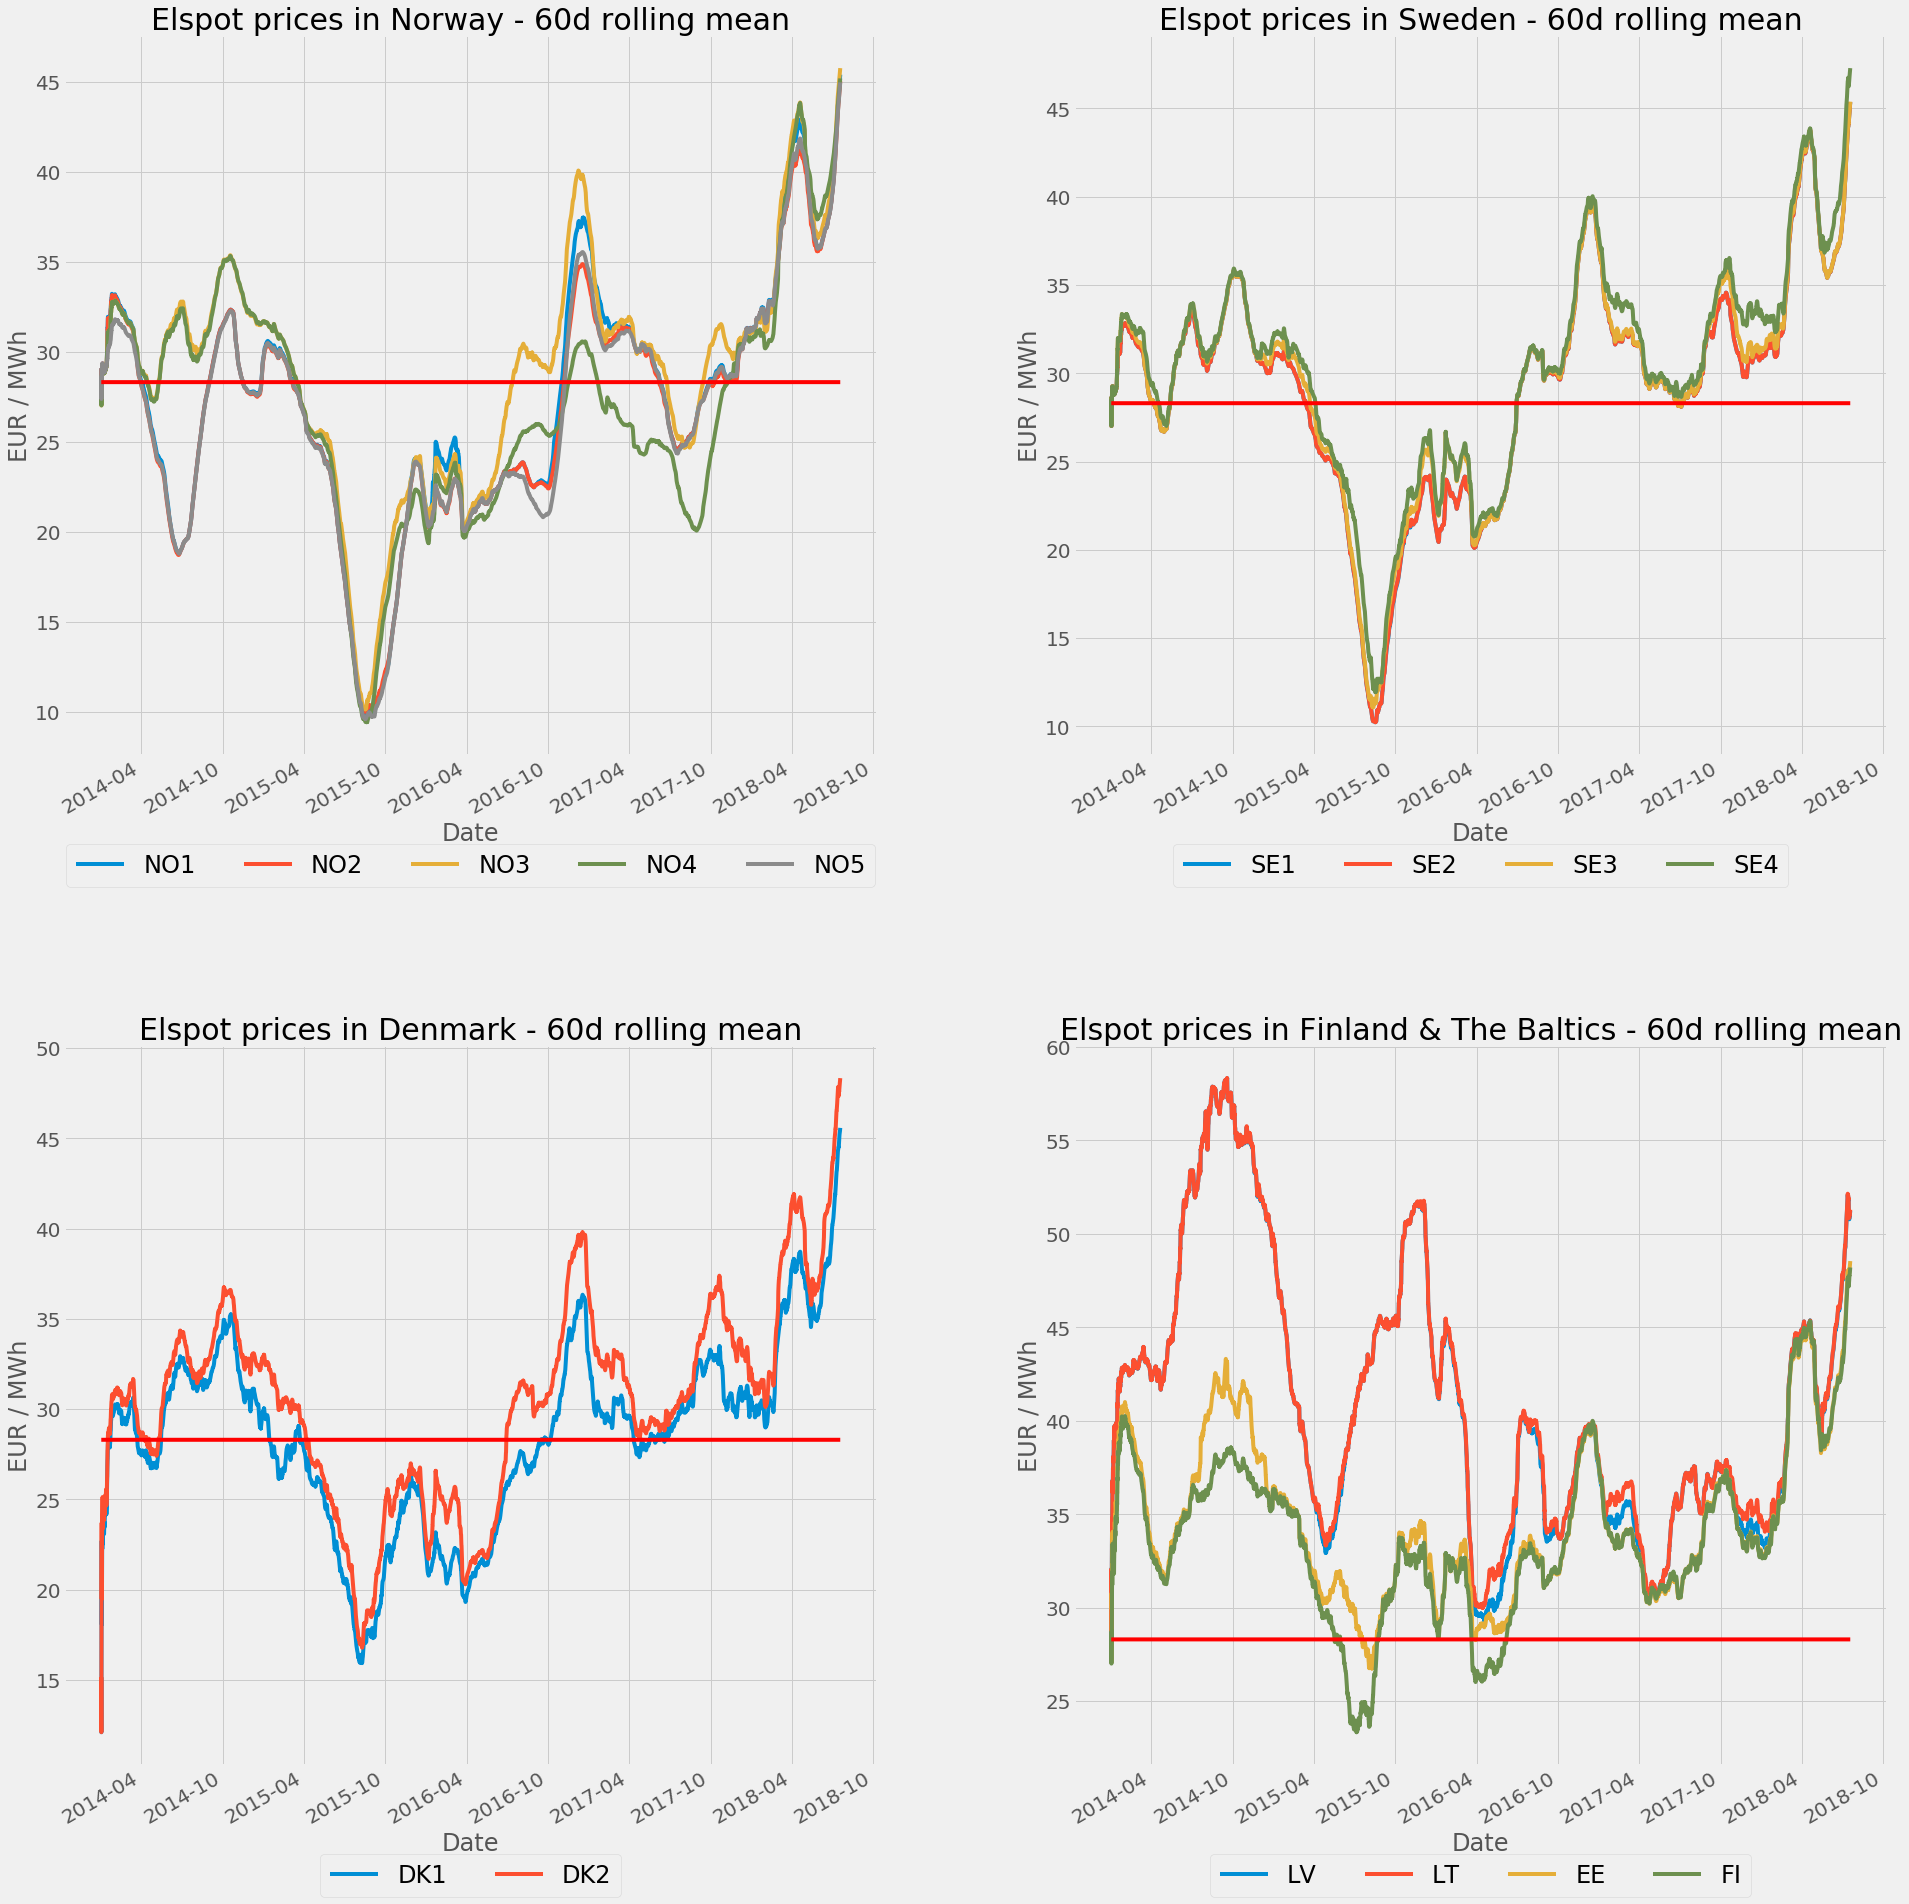

In [118]:
# Create lists of zones specific to each country. Baltics and Finland is grouped together as
# each country as one zone only


plt.style.use("fivethirtyeight")
norway = ["NO1", "NO2", "NO3", "NO4", "NO5"]
sweden = ["SE1", "SE2", "SE3", "SE4"]
denmark = ["DK1", "DK2"]
baltics_fin = ["LV", "LT", "EE", "FI"]


# Make 60 day moving window average of prices to smooth out the curves
elspot_df_smoothed = elspot_df.rolling("60d").mean()


# Plot Norway
plt.subplot(2,2,1)

for zone in norway:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 60]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Norway - 60d rolling mean", fontsize=30)

# Plot Sweden
plt.subplot(2,2,2)

for zone in sweden:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Sweden - 60d rolling mean", fontsize=30)

# Plot Denmark
plt.subplot(2,2,3)

for zone in denmark:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Denmark - 60d rolling mean", fontsize=30)

# Plot Baltics & Finland 
plt.subplot(2,2,4)

for zone in baltics_fin:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Finland & The Baltics - 60d rolling mean", fontsize=30)


plt.tight_layout(pad=10)

There are of some interesting observations from this. First of all, there are clear price differences within each country, except for **Sweden** where the four bidding areas have approximately the same price for most of the period we're looking at. In **Norway**, there's a large discrepancy between the prices, except in certain periods where the price is very similar. In **Denmark**, the eastern bidding area consistently lies above the western, and in the **Baltics**, Latvia and Lithuenia has historically experienced much larger prices than in Estonia, however, this seems to have changed the past year. **Finland** has been at a level below the Baltics, but they are all generally well above the mean system price.

In [89]:
elspot_df["Norway"] = elspot_df[norway].mean(axis=1)
elspot_df["Sweden"] = elspot_df[sweden].mean(axis=1)
elspot_df["Denmark"] = elspot_df[denmark].mean(axis=1)
elspot_df["Baltics_Finland"] = elspot_df[baltics_fin].mean(axis=1)

print("Mean in Norway: " + str(elspot_df["Norway"].mean()))
print("Mean in Sweden: " + str(elspot_df["Sweden"].mean()))
print("Mean in Denmark: " + str(elspot_df["Denmark"].mean()))
print("Mean in Baltics & Finland: " + str(elspot_df["Baltics_Finland"].mean()))



Mean in Norway: 27.539286628680827
Mean in Sweden: 29.86617228093066
Mean in Denmark: 29.846203970983282
Mean in Baltics & Finland: 37.84169450789504


# 4. Seasonal variations

Let's look at seasonal variations, and how the prices change from months to month and quarter to quarter.

In [90]:
# Extract years in different dataframes
elspot_df_2014 = elspot_df.loc["2014"]
elspot_df_2015 = elspot_df.loc["2015"]
elspot_df_2016 = elspot_df.loc["2016"]
elspot_df_2017 = elspot_df.loc["2017"]
elspot_df_2018 = elspot_df.loc["2018"]

# 

print(elspot_df[["Molde", "Trondheim"]].head(48))

KeyError: "['Molde' 'Trondheim'] not in index"